This notebook extracts the surface from the `proc??????_reg1_alpha_kernel.bin`
files and combines them into a single file, `reg_1_surface_alpha_kernel.npz`.

The code in this notebook is made available under the [GPLv2 license](../LICENSE.md).

In [1]:
from collections import defaultdict
import os
from multiprocessing import Pool

import numpy as np

# Plotting
%matplotlib nbagg
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Fancy progress bars
from tqdm import tqdm

In [2]:
# Some values from constants.h
R_EARTH = 6371000
R_EARTH_KM = R_EARTH / 1000
FLATTENING_F = 1.0 / 299.8e0
ONE_MINUS_F_SQUARED = (1.0 - FLATTENING_F)**2
FACTOR_TAN = 1.0 / ONE_MINUS_F_SQUARED
TINYVAL = 1.0e-9
NGLL = 5

In [3]:
# NOTE: The mesh should be the same no matter which method is used.
BASEDIR = 'exact/step1-forward/DATA'

In [4]:
cmt = os.path.join(BASEDIR, 'CMTSOLUTION')
sta = os.path.join(BASEDIR, 'STATIONS_ADJOINT')
parfile = os.path.join(BASEDIR, 'Par_file')

# Load simulation information

In [5]:
# Obtain simulation parameters
config = {}
with open(parfile, 'r') as f:
    for line in f:
        line = line.split('#')[0]
        if not line:
            continue
        line = line.strip()
        if not line:
            continue

        var, value = [x.strip() for x in line.split('=', maxsplit=1)]
        config[var] = value

NCHUNKS = int(config['NCHUNKS'])
NPROC_XI = int(config['NPROC_XI'])
NPROC_ETA = int(config['NPROC_ETA'])
NEX_XI = int(config['NEX_XI'])
NEX_ETA = int(config['NEX_ETA'])
print("NCHUNKS = %d, NPROC_XI = %d, NEX_XI = %d, NPROC_ETA = %d, NEX_ETA = %d" % (
        NCHUNKS, NPROC_XI, NEX_XI, NPROC_ETA, NEX_ETA))

if NCHUNKS != 6:
    ANGULAR_WIDTH_XI_IN_DEGREES = float(config['ANGULAR_WIDTH_XI_IN_DEGREES'].replace('d', 'e'))
    ANGULAR_WIDTH_ETA_IN_DEGREES = float(config['ANGULAR_WIDTH_ETA_IN_DEGREES'].replace('d', 'e'))
    CENTER_LATITUDE_IN_DEGREES = float(config['CENTER_LATITUDE_IN_DEGREES'].replace('d', 'e'))
    CENTER_LONGITUDE_IN_DEGREES = float(config['CENTER_LONGITUDE_IN_DEGREES'].replace('d', 'e'))
    GAMMA_ROTATION_AZIMUTH = float(config['GAMMA_ROTATION_AZIMUTH'].replace('d', 'e'))
    print("xi_width = %f, eta_width = %f; clat = %f, clon = %f; grot = %f" % (
        ANGULAR_WIDTH_XI_IN_DEGREES, ANGULAR_WIDTH_ETA_IN_DEGREES,
        CENTER_LATITUDE_IN_DEGREES, CENTER_LONGITUDE_IN_DEGREES, GAMMA_ROTATION_AZIMUTH))
else:
    ANGULAR_WIDTH_XI_IN_DEGREES = ANGULAR_WIDTH_ETA_IN_DEGREES = 90.0
    CENTER_LATITUDE_IN_DEGREES = CENTER_LONGITUDE_IN_DEGREES = GAMMA_ROTATION_AZIMUTH = None

ANGULAR_WIDTH_XI_RAD = np.deg2rad(ANGULAR_WIDTH_XI_IN_DEGREES)
ANGULAR_WIDTH_ETA_RAD = np.deg2rad(ANGULAR_WIDTH_ETA_IN_DEGREES)

NCHUNKS = 6, NPROC_XI = 8, NEX_XI = 256, NPROC_ETA = 8, NEX_ETA = 256


# Data loading functions

In [6]:
def read_fortran_record(f, dtype='f4', count=1):
    dtype = np.dtype(dtype)
    count_dtype = np.dtype('u4').newbyteorder(dtype.byteorder)

    n1 = np.fromfile(f, dtype=count_dtype, count=1)
    assert n1 == count * dtype.itemsize, \
        'Expected: %u, Got: %u' % (count * dtype.itemsize, n1)

    data = np.fromfile(f, dtype=dtype, count=count)

    n2 = np.fromfile(f, dtype=count_dtype, count=1)
    assert n2 == count * dtype.itemsize, \
        'Expected: %u, Got: %u' % (count * dtype.itemsize, n2)

    return data

In [7]:
def load_mesh(f):
    nspec = read_fortran_record(f, 'u4')
    nglob = read_fortran_record(f, 'u4')
    nelem = NGLL * NGLL * NGLL * nspec

    xstore = read_fortran_record(f, count=nglob)
    ystore = read_fortran_record(f, count=nglob)
    zstore = read_fortran_record(f, count=nglob)
    ibool = read_fortran_record(f, dtype='u4', count=nelem).reshape((NGLL, NGLL, NGLL, nspec),
                                                                    order='F')

    rstore = np.sqrt(xstore**2 + ystore**2 + zstore**2)
    thetastore = np.arctan2(np.hypot(xstore, ystore), zstore)
    phistore = np.arctan2(ystore, xstore)
    phistore[phistore < 0] += 2 * np.pi
    thetastore = np.arctan(FACTOR_TAN * np.cos(thetastore) / np.maximum(TINYVAL, np.sin(thetastore)))

    latstore = np.rad2deg(thetastore)
    lonstore = np.rad2deg(phistore)

    return rstore, latstore, lonstore, ibool

In [8]:
def load_slice(topo_dir, kernel_dir, slice_number):
    filename = os.path.join(topo_dir, 'proc%06d_reg1_solver_data.bin' % (slice_number, ))
    with open(filename, 'rb') as f:
        r, lat, lon, ibool = load_mesh(f)
    assert np.all(ibool != -1)

    filename = os.path.join(kernel_dir, 'proc%06d_reg1_alpha_kernel.bin' % (slice_number, ))
    with open(filename, 'rb') as f:
        data = read_fortran_record(f, count=ibool.size).reshape((NGLL, NGLL, NGLL, -1),
                                                                order='F')

    return r, lat, lon, ibool, data

In [9]:
def find_surface(local_to_global, global_to_local, nglob, max_point):
    surface = np.zeros(nglob, dtype=np.bool_)
    points_to_check = list(global_to_local[max_point + 1])
    while points_to_check:
        i, j, k, ispec = points_to_check.pop()
        iglob = local_to_global[i, j, k, ispec] - 1
        if not surface[iglob]:
            surface[iglob] = True
            points_to_check.extend(global_to_local[iglob + 1])

        # Points to left/right
        if i > 0:
            iglob = local_to_global[i - 1, j, k, ispec] - 1
            if not surface[iglob]:
                surface[iglob] = True
                points_to_check.extend(global_to_local[iglob + 1])
        if i < 4:
            iglob = local_to_global[i + 1, j, k, ispec] - 1
            if not surface[iglob]:
                surface[iglob] = True
                points_to_check.extend(global_to_local[iglob + 1])

        # Points above/below
        if j > 0:
            iglob = local_to_global[i, j - 1, k, ispec] - 1
            if not surface[iglob]:
                surface[iglob] = True
                points_to_check.extend(global_to_local[iglob + 1])
        if j < 4:
            iglob = local_to_global[i, j + 1, k, ispec] - 1
            if not surface[iglob]:
                surface[iglob] = True
                points_to_check.extend(global_to_local[iglob + 1])

    return surface

In [10]:
def find_neighbours(local_to_global, global_to_local, index):
    neighbours = np.empty(index.shape + (5, ), dtype=np.intp)
    neighbours.fill(-1)
    neighbours[:, 0] = index

    for ineigh, iglob in enumerate(index):
        for i, j, k, ispec in global_to_local[iglob + 1]:
            # Points to left/right
            if i > 0:
                iglob_left = local_to_global[i - 1, j, k, ispec] - 1
                neighbours[ineigh, 1] = iglob_left
            if i < 4:
                iglob_right = local_to_global[i + 1, j, k, ispec] - 1
                neighbours[ineigh, 2] = iglob_right

            # Points above/below
            if j > 0:
                iglob_below = local_to_global[i, j - 1, k, ispec] - 1
                neighbours[ineigh, 3] = iglob_below
            if j < 4:
                iglob_above = local_to_global[i, j + 1, k, ispec] - 1
                neighbours[ineigh, 4] = iglob_above

    return neighbours

In [11]:
def create_gridded_surface(r, lat, lon, data, global_to_local, surface_index, neighbours):
    nx = NEX_XI // NPROC_XI * (NGLL - 1) + 1
    ny = NEX_ETA // NPROC_ETA * (NGLL - 1) + 1

    lat_grid = np.empty((nx + 1, ny + 1))
    lon_grid = np.empty_like(lat_grid)
    r_grid = np.empty((nx, ny))
    data_grid = np.empty_like(r_grid)

    # To convert global neighbours into surface neighbours.
    global_to_surf = {iglob: ineed for ineed, iglob in enumerate(surface_index)}

    # Bottom is where no neighbours below.
    bottom = neighbours[:, 3] == -1

    # Left edge is where no neighbours to left.
    bottom_left = np.where(bottom & (neighbours[:, 1] == -1))[0]
    assert len(bottom_left) == 1
    bottom_left = surface_index[bottom_left[0]]

    # Right edge is where no neighbours to right.
    bottom_right = np.where(bottom & (neighbours[:, 2] == -1))[0]
    assert len(bottom_right) == 1
    bottom_right = surface_index[bottom_right[0]]

    # Note, "bottom-left" is arbitrary, so this is minimum GLL point.
    point = bottom_left
    # Go left-to-right:
    for x in range(nx):
        bottom_point_this_column = point

        # Go bottom-to-top:
        for y in range(ny):
            ineigh = global_to_surf[point]
            iglob, iglob_left, iglob_right, iglob_below, iglob_above = neighbours[ineigh, :]
            assert iglob == point

            # Create a grid out of the GLL points. The quads are aligned with the edges,
            # but halfway between GLL points in the interior.
            this_lat = lat[iglob]
            this_lon = lon[iglob]
            npoint = 1
            if x == 0:
                if y > 0:
                    # Left edge, not at bottom: average this and below point.
                    this_lat += lat[iglob_below]
                    this_lon += lon[iglob_below]
                    npoint += 1
            else:
                if y == 0:
                    # Not at left edge, but at bottom: average this and left point.
                    this_lat += lat[iglob_left]
                    this_lon += lon[iglob_left]
                    npoint += 1
                else:
                    # Not at left or bottom edges: average this, left, below, and below-left point.
                    this_lat += lat[iglob_below]
                    this_lon += lon[iglob_below]
                    this_lat += lat[iglob_left]
                    this_lon += lon[iglob_left]
                    other = global_to_surf[iglob_left]
                    iglob_left_below = neighbours[other, 3]
                    this_lat += lat[iglob_left_below]
                    this_lon += lon[iglob_left_below]
                    npoint += 3

            lat_grid[x, y] = this_lat / npoint
            lon_grid[x, y] = this_lon / npoint
            # The radius and data are cell-centred; no shifting or averaging needed.
            r_grid[x, y] = r[iglob]
            tmp = 0
            for i, j, k, ispec in global_to_local[iglob + 1]:
                tmp += data[i, j, k, ispec]
            data_grid[x, y] = tmp / len(global_to_local[iglob + 1])

            # Move up.
            point = iglob_above

        # Calculate the top edge. Just check if at left edge:
        if x != 0:
            lon_grid[x, ny] = (lon[iglob] + lon[iglob_left]) / 2
            lat_grid[x, ny] = (lat[iglob] + lat[iglob_left]) / 2
        else:
            lon_grid[x, ny] = lon[iglob]
            lat_grid[x, ny] = lat[iglob]

        # Move to the right.
        ineigh = global_to_surf[bottom_point_this_column]
        iglob, iglob_left, iglob_right, iglob_below, iglob_above = neighbours[ineigh, :]
        assert iglob == bottom_point_this_column
        point = iglob_right

    # Calculate the right edge:
    point = bottom_right
    for y in range(ny):
        ineigh = global_to_surf[point]
        iglob, iglob_left, iglob_right, iglob_below, iglob_above = neighbours[ineigh, :]
        assert iglob == point

        # At far right, just check if need to average with one below:
        if y != 0:
            lat_grid[nx, y] = (lat[iglob] + lat[iglob_below]) / 2
            lon_grid[nx, y] = (lon[iglob] + lon[iglob_below]) / 2
        else:
            lat_grid[nx, y] = lat[iglob]
            lon_grid[nx, y] = lon[iglob]

        # Move up:
        point = iglob_above

    # Very last point at the top-right corner:
    lat_grid[nx, ny] = lat[iglob]
    lon_grid[nx, ny] = lon[iglob]

    return lat_grid, lon_grid, r_grid, data_grid

In [12]:
def load_surface_grid(topo_dir, kernel_dir, slice_number):
    # Expected size of the surface.
    nx = NEX_XI // NPROC_XI * (NGLL - 1) + 1
    ny = NEX_ETA // NPROC_ETA * (NGLL - 1) + 1
    nsurf = nx * ny

    r, lat, lon, ibool, data = load_slice(topo_dir, kernel_dir, slice_number)

    # This mapping takes the majority of the time in this entire script, but
    # makes many things simpler. Various other methods are not particularly faster,
    # probably due to the variable number of local points for each global point.
    global_to_local = defaultdict(list)
    for ispec in range(ibool.shape[-1]):
        for k in range(NGLL):
            for j in range(NGLL):
                for i in range(NGLL):
                    iglob = ibool[i, j, k, ispec]
                    global_to_local[iglob].append((i, j, k, ispec))

    max_point = r.argmax()
    surface = find_surface(ibool, global_to_local, r.shape[0], max_point)
    surface_index = np.where(surface)[0]
    assert len(surface_index) == nsurf
    neighbours = find_neighbours(ibool, global_to_local, surface_index)

    return create_gridded_surface(r, lat, lon, data, global_to_local, surface_index, neighbours)

# Verify loading works correctly

In [13]:
lat_grid15, lon_grid15, r_grid15, data_grid15 = load_surface_grid(
    'ppd/step2-adjoint/100s-200s/DATABASES_MPI',
    'ppd/step2-adjoint/100s-200s/DATABASES_MPI_kernel',
    15)

In [14]:
lat_grid21, lon_grid21, r_grid21, data_grid21 = load_surface_grid(
    'ppd/step2-adjoint/100s-200s/DATABASES_MPI',
    'ppd/step2-adjoint/100s-200s/DATABASES_MPI_kernel',
    21)

In [15]:
lat_grid22, lon_grid22, r_grid22, data_grid22 = load_surface_grid(
    'ppd/step2-adjoint/100s-200s/DATABASES_MPI',
    'ppd/step2-adjoint/100s-200s/DATABASES_MPI_kernel',
    22)

<IPython.core.display.Javascript object>


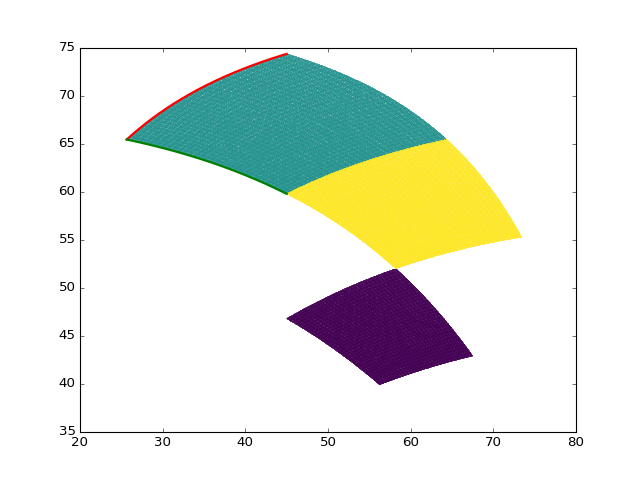

In [16]:
f, ax = plt.subplots()

ax.pcolormesh(lon_grid15, lat_grid15, np.ones_like(r_grid15)*0, alpha=0.5, vmin=0, vmax=2, cmap='viridis')
ax.pcolormesh(lon_grid21, lat_grid21, np.ones_like(r_grid21)*1, alpha=0.5, vmin=0, vmax=2, cmap='viridis')
ax.pcolormesh(lon_grid22, lat_grid22, np.ones_like(r_grid22)*2, alpha=0.5, vmin=0, vmax=2, cmap='viridis')
ax.plot(lon_grid21[0, :], lat_grid21[0, :], lw=2, c='r')
ax.plot(lon_grid21[:, 0], lat_grid21[:, 0], lw=2, c='g')

Double-check the orientation of the slices relative to the numbering within a chunk:

<IPython.core.display.Javascript object>


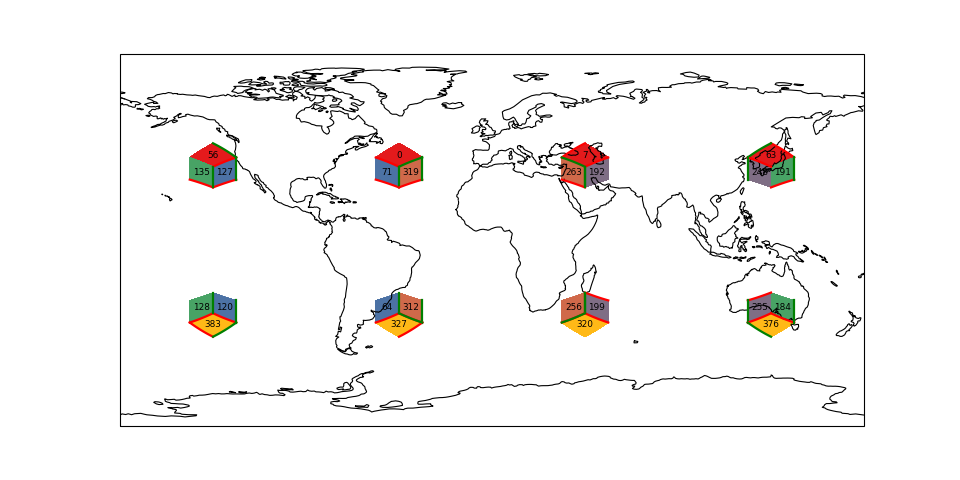

In [17]:
f = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()

for i, slice_number in tqdm(enumerate([0, 7, 56, 63,
                                       64, 71, 120, 127,
                                       128, 135, 184, 191,
                                       192, 199, 248, 255,
                                       256, 263, 312, 319,
                                       320, 327, 376, 383]), total=6 * 4):
    lat_grid, lon_grid, r_grid, data_grid = load_surface_grid(
        'ppd/step2-adjoint/100s-200s/DATABASES_MPI',
        'ppd/step2-adjoint/100s-200s/DATABASES_MPI_kernel',
        slice_number)

    ax.pcolormesh(lon_grid, lat_grid, np.ones_like(r_grid) * (i // 4),
                  alpha=0.5, vmin=0, vmax=9, cmap='Set1', transform=ccrs.PlateCarree())
    ax.text(np.average(lon_grid), np.average(lat_grid), str(slice_number),
            fontsize=8, horizontalalignment='center', verticalalignment='center',
            transform=ccrs.Geodetic())

    # Indicate orientation of slice:
    ax.plot(lon_grid[0, :], lat_grid[0, :],
            lw=2, c='r', transform=ccrs.Geodetic())
    ax.plot(lon_grid[:, 0], lat_grid[:, 0],
            lw=2, c='g', transform=ccrs.Geodetic())
    
del r_grid, lat_grid, lon_grid, data_grid

# Load all visible slices and place in grid

In [18]:
def load_kernel_surface(slices, rotation, topo_dir, kernel_dir, nested=False):
    slice_height = (NEX_XI // NPROC_XI) * (NGLL - 1) + 1
    slice_width = (NEX_ETA // NPROC_ETA) * (NGLL - 1) + 1
    height = (slice_height - 1) * slices.shape[0] + 1
    width = (slice_width - 1) * slices.shape[1] + 1

    lat = np.zeros((height + 1, width + 1))
    lon = np.zeros_like(lat)
    data = np.zeros((height, width))
    mask = np.zeros_like(data, dtype=np.bool_)

    process_pool = Pool()

    it = np.nditer(slices, flags=['multi_index'])
    results = []
    for this_slice in it:
        row, col = it.multi_index

        row_offset = row * (slice_height - 1)
        col_offset = col * (slice_width - 1)

        if this_slice == -1:
            mask[row_offset:row_offset + slice_height,
                 col_offset:col_offset + slice_width] = True
            continue

        ret = process_pool.apply_async(load_surface_grid,
                                       args=(topo_dir, kernel_dir, this_slice))
        results.append((row, col, row_offset, col_offset, ret))

    process_pool.close()
    process_pool.join()

    for row, col, row_offset, col_offset, ret in results:
        lat_grid, lon_grid, r_grid, data_grid = ret.get()
        rot = rotation[row, col]

        lat[row_offset:row_offset + slice_height + 1,
            col_offset:col_offset + slice_width + 1] = np.rot90(lat_grid, rot)

        lon[row_offset:row_offset + slice_height + 1,
            col_offset:col_offset + slice_width + 1] = np.rot90(lon_grid, rot)

        data[row_offset:row_offset + slice_height,
             col_offset:col_offset + slice_width] = np.rot90(data_grid, rot)

    data = np.ma.MaskedArray(data, mask)
    return lat, lon, data

# All kernels

In [19]:
UNDO_TYPES = ['exact', 'ppd', 'undo']
FILTERS = ['50s-100s', '100s-200s']

In [20]:
with np.load('slices.npz') as data:
    slices = data['grid']
    rotation = data['rotation']

In [21]:
all_data = {}
for undo_type in tqdm(UNDO_TYPES, desc='undo types'):
    all_data[undo_type] = {}

    for filt in tqdm(FILTERS, desc='filters', nested=True):
        topo_dir = os.path.join(undo_type, 'step2-adjoint', filt, 'DATABASES_MPI')
        kernel_dir = os.path.join(undo_type, 'step2-adjoint', filt, 'DATABASES_MPI_kernel')

        lat, lon, data = load_kernel_surface(slices, rotation,
                                             topo_dir, kernel_dir,
                                             nested=True)

        all_data[undo_type][filt] = (lat, lon, data)

undo types:  67%|██████▋   | 2/3 [08:05<04:05, 245.07s/it]


In [22]:
for undo_type in UNDO_TYPES:
    for filt in FILTERS:
        filename = os.path.join(undo_type, 'step2-adjoint', filt,
                                'OUTPUT_FILES', 'reg_1_surface_alpha_kernel.npz')
        lat, lon, data = all_data[undo_type][filt]
        np.savez_compressed(filename,
                            latitude=lat, longitude=lon,
                            alpha_kernel=data.data, alpha_kernel_mask=data.mask)

# License Statement
Copyright (C) 2016  Elliott Sales de Andrade

This program is free software; you can redistribute it and/or
modify it under the terms of the GNU General Public License
as published by the Free Software Foundation; either version 2
of the License, or (at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program; if not, write to the Free Software
Foundation, Inc., 51 Franklin Street, Fifth Floor, Boston, MA  02110-1301, USA.